## Demo Notebook for light curve fitting with exoTEDRF

There are many wonderful light curve fitting tutorials elsewhere, so this notebook will provide a really quick overview of how one might choose to fit their extracted light curves.

Let's start off by defining some input and output directory paths.

In [1]:
outdir_s3 = 'pipeline_outputs_directory/Stage3/'
outdir_s4 = 'pipeline_outputs_directory/Stage4/'

Now we're going to do is open the WASP-39b spectra we extracted in the previous tutorial. 

In [2]:
from astropy.io import fits
import numpy as np

# Open the extracted spectrum file and get the relevant quantities.

with fits.open(outdir_s3 + 'WASP-39_box_spectra_fullres.fits') as spec:
    
    wave1 = np.mean([spec[1].data[0], spec[2].data[0]], axis=0)  # Order 1 wavelengths
    wave2 = np.mean([spec[5].data[0], spec[6].data[0]], axis=0)  # Order 2 wavelengths
    
    order1 = spec[3].data  # Order 1 spectra
    order2 = spec[7].data  # Order 2 spectra
    
    t = spec[9].data  # Time stamps for each integration
    
base = np.concatenate([np.arange(150), np.arange(100)-100]).astype(int) # Baseline ints
    
# Normalize the extracted spectra.  

order1_norm = order1 / np.nanmedian(order1[base], axis=0)
order2_norm = order2 / np.nanmedian(order2[base], axis=0)

/tmp/ipykernel_2673514/3379126671.py:20: RuntimeWarning: invalid value encountered in divide
  order1_norm = order1 / np.nanmedian(order1[base], axis=0)
/tmp/ipykernel_2673514/3379126671.py:21: RuntimeWarning: invalid value encountered in divide
  order2_norm = order2 / np.nanmedian(order2[base], axis=0)


We already did this, but let's look at the 2D light curves again because they're just so amazing!!

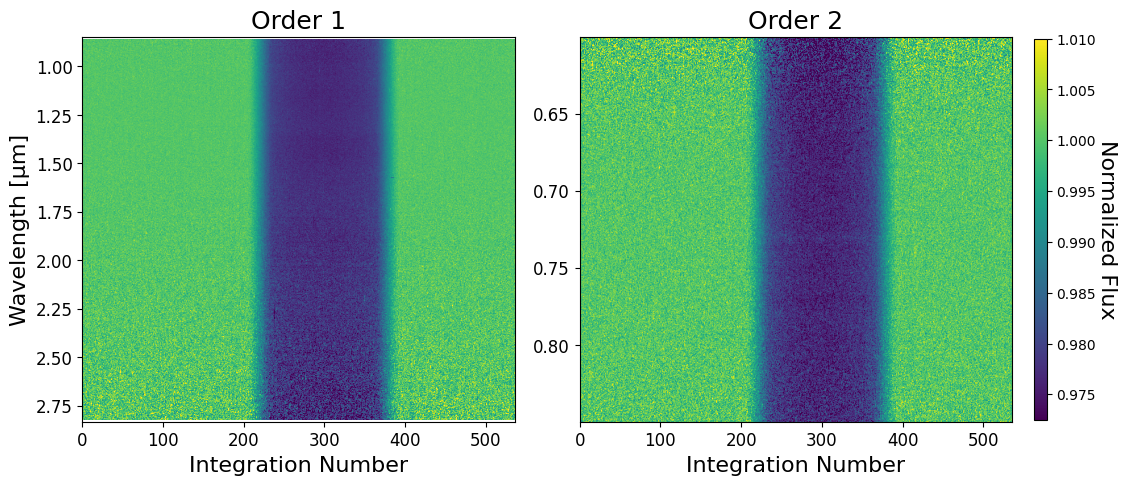

In [3]:
from exotedrf.plotting import make_2d_lightcurve_plot

# For order 2, only the wavelengths from 0.6 -- 0.85µm are useable.

ii = np.where((wave2 >= 0.6) & (wave2 < 0.85))[0]

# Display the light curves.

kwargs = {'vmin': 0.9725, 'vmax': 1.01}
make_2d_lightcurve_plot(wave1, order1_norm, wave2[ii], order2_norm[:, ii], **kwargs)

Now let's get the white light curves. Generally, people have made sepearte white light curves for the first and second order, and then jointly fitted the two light curves. Though, of course, there's nothing stopping you from simply summing all flux from both orders into one single white light curve. 

To keep things simple, in this case, we're simply going to concern ourselves with order 1.

In [4]:
# Sum along the wavelength axis to get the order 1 white light curve

wlc = np.nansum(order1, axis=1)
wlc /= np.nanmedian(wlc[base], axis=0)  # Normalize by the baseline flux.

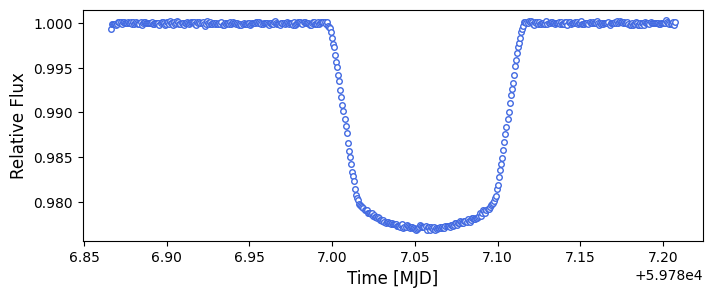

In [5]:
import matplotlib.pyplot as plt

# Display the white light curve.

plt.figure(figsize=(8, 3))
plt.errorbar(t, wlc, fmt='o', mec='royalblue', mfc='white', ms=4)
plt.ylabel('Relative Flux', fontsize=12)
plt.xlabel('Time [MJD]', fontsize=12)
plt.show()

Very nice!

You may notice a small settling ramp and a couple of outliers at the beginning and end of each time series. This is common across instruments. Generally, discluding the first and last 10 integrations or so is a good way to deal with these effects. 

Now let's fit the white light curve. We're going to use the brilliant juliet package, whose documentation can be found [here](https://juliet.readthedocs.io/en/latest/).

The first thing to do is to set up the priors. We're going to do a very basic fit, like what was done for this dataset in [Feinstein & Radica et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023Natur.614..670F/abstract); this includes a simple linear trend systematics model in addition to the transit model. For more precise fits, you may consider using the principal components we derived during Stage 2, or a Gaussian Process. 

In [6]:
import juliet

# Define the priors. 

params = ['P_p1', 't0_p1', 'p_p1_SOSS1', 'b_p1', 'ecc_p1', 'omega_p1', 'a_p1',
          'q1_SOSS', 'q2_SOSS', 
          'mdilution_SOSS', 'mflux_SOSS', 'sigma_w_SOSS',
          'theta0_SOSS', 'theta1_SOSS']

dists = ['fixed', 'uniform', 'uniform', 'uniform', 'fixed', 'fixed', 'uniform',
         'uniform', 'uniform',
         'fixed', 'fixed', 'loguniform', 
         'uniform', 'uniform']

hyperps = [4.055259, [59787.0, 59787.15], [1e-2, 0.9], [1e-2, 0.99], 0, 90, [1, 30],
           [0, 1], [0, 1], 
           1, 0, [1e-1, 1e5], 
           [-1, 1], [-1, 1]]

In [7]:
# Populate the priors dictionary. 

priors = {}
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp
    
# Format the regressor for the systematics model.

tt = np.zeros((len(t), 2))
tt[:, 0] = np.ones_like(t)
tt[:, 1] = (t - np.mean(t)) / np.sqrt(np.var(t))

In [8]:
# Ready the juliet dataset.

dataset = juliet.load(priors=priors, t_lc={'SOSS': t[10:-10]}, 
                      y_lc={'SOSS': wlc[10:-10]}, 
                      yerr_lc={'SOSS': 0*wlc[10:-10]},  # We're going to fit for the error bar.
                      linear_regressors_lc={'SOSS': tt[10:-10]},
                      out_folder=outdir_s4+'wlc_linwitht')

# And run the fit!
# This shouldn't take too long, about five minutes or so given that it's a pretty simple fit.

results = dataset.fit(sampler='dynesty')

34043it [03:26, 164.52it/s, +500 | bound: 434 | nc: 1 | ncall: 954717 | eff(%):  3.620 | loglstar:   -inf < 3989.172 <    inf | logz: 3921.741 +/-  0.359 | dlogz:  0.001 >  0.509]


We've used dynesty nested sampling for the above fit. This is great because for each fit you also get the Bayesian evidence, allowing you to compare fit using different detrending techniques to see which is the most justified given the data!

Let's now see how this fit turned out. First we'll open and calculate some relevant quantities

In [9]:
# Get the best fitting model from juliet.

transit_model, comp = results.lc.evaluate('SOSS', return_components=True)

# The "systematics" component is everything that isn't the transit model.

sys = transit_model - comp['p1']

# We also want the time of mid-transit and the fitted scatter.

t0 = np.nanmedian(results.posteriors['posterior_samples']['t0_p1'])
scatter = np.median(results.posteriors['posterior_samples']['sigma_w_SOSS'])

# And an estimate of the out-of-transit scatter pre-fit.

out_dev = np.median(np.abs(0.5*(wlc[0:-2]+wlc[2:]) - wlc[1:-1]))

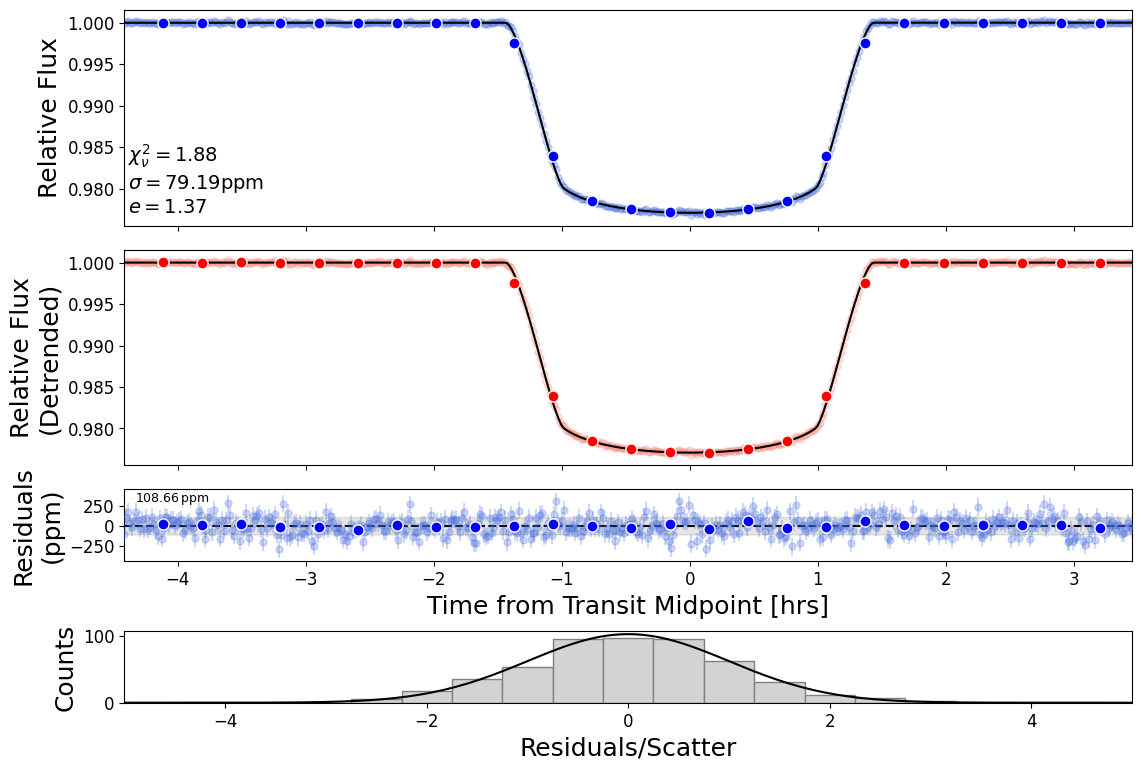

In [10]:
# Now let's make a plot!

from exotedrf.plotting import make_lightcurve_plot

make_lightcurve_plot((dataset.times_lc['SOSS']-t0)*24, dataset.data_lc['SOSS'],
                     transit_model, scatter, out_dev, nfit=9, systematics=sys, 
                     nbin=20)

Not bad for a first pass! The top panel (blue) shows the full fit, whereas the second panel (red) shows the data after systematics correction. In this case we can see there isn't too much of a difference. 

The $\chi^2$ value is also slightly higher than we'd like it to be, and we can see that there is clearly still some correlated noise in the residuals. Perhaps detrending against the PCs could improve this?

Once you're happy with the white light curve fit, you're ready to move on to getting your transit spectrum! The exoTEDRF light curve fitting functionalities are contained with Stage 4. A fit_lightcurves.py script is also provided for a simple light curve analysis (essentially it's a wrapper around the code above). Simply fill out the corresponding yaml file, and you're good to go!

Below is an example of the WASP-39b transmission spectrum that I get following the above procedure and using 20-pixel bins. This is not necessarily an optimized spectrum, but its a good comparison to make sure that you're on the right track!

In [11]:
# Open the WASP-39b transmission spectrum.

import pandas as pd

spec = pd.read_csv('../data/WASP-39b_NIRISS_SOSS_transmission_spectrum_20pix.csv', comment='#')

<div class="alert alert-block alert-info"> <b>NOTE:</b> This isn't the same spectrum presented in Feinstein & Radica et al. (2023). We've learned a lot about JWST since then, and this version is actually quite a bit cleaner! </div>

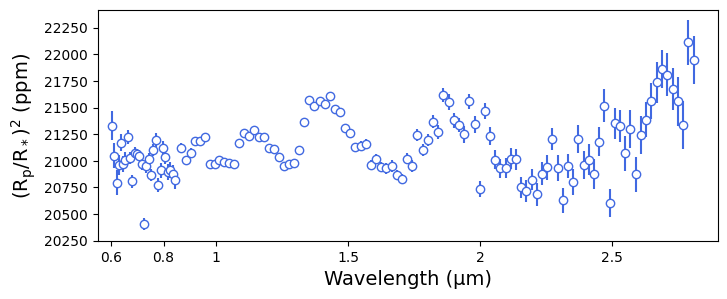

In [12]:
# Plot transmission spectrum.

plt.figure(figsize=(8, 3), facecolor='white')

plt.errorbar(spec['wave'].values, spec['dppm'].values, 
             yerr=spec['dppm_err'].values, xerr=spec['wave_err'].values,
             fmt='o', mec='royalblue', mfc='white', ecolor='royalblue', ms=6)

plt.xlabel('Wavelength (µm)', fontsize=14)
plt.ylabel(r'$\rm (R_p/R_*)^2$ (ppm)', fontsize=14)
plt.xlim(0.55, 2.9)
plt.xticks([0.6, 0.8, 1, 1.5, 2, 2.5], labels=['0.6', '0.8', '1', '1.5', '2', '2.5'], 
           fontsize=10)
plt.yticks(fontsize=10)
plt.show()